In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.ar_model import AR

% matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 12, 4
matplotlib.rcParams['figure.dpi'] = 300

import matplotlib.pyplot as plt
plt.style.use('bmh')

from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

In [2]:
data = pd.read_csv('post2009_naics.csv', parse_dates=['CASE_SUBMITTED'])
data = data[(data['CASE_SUBMITTED'] >= '2013-06-01') & (data['CASE_SUBMITTED'] < '2017-06-01')]

In [3]:
def autoplot_test(data, title='Forecast of Demand for H-1B Visas', ylim=(-0.1e5, 1.1e5)):
    """
    pass
    """
    # Sum Total Workers for Each Date
    data = data.groupby('CASE_SUBMITTED').sum()
    
    # Convert Index to DatetimeIndex
    data.index = pd.to_datetime(data.index)
    
    # Group Data by Semi-Month Start Frequency (SMS)
    data = data.resample('W-WED', closed='left', label='left').sum()
    
    # Remove NaNs
    data['TOTAL_WORKERS'] = np.nan_to_num(data)
    
    # Model
    END = data.shape[0] - 1
    START = END - 53
    
    model = AR(data['TOTAL_WORKERS']).fit(maxlag=52)
    y_hat = model.predict(START, END, dynamic=True)    
    y_hat.loc[data.index[START]] = data.iloc[START][0]
    
    y_true = data.iloc[START:].values
    y_pred = np.array(y_hat).reshape(len(y_hat), 1)
    
    START = '2016-05-25'
    END = '2017-05-31'
    
    y_hat.index = pd.date_range(START, END, freq='W-WED')
    y_hat.index = [dt.datetime.strftime(date, '%Y-%m-%d') for date in y_hat.index]
    y_hat.index = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in y_hat.index]
    
    # ¯\_(ツ)_/¯ Code Needs This to Work
    data.index = [dt.datetime.strftime(date, '%Y-%m-%d') for date in data.index]
    data.index = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in data.index]
    
    # Visualization
    ax = plt.gca()
    
    ax.plot(
        data['TOTAL_WORKERS'],
        label='y_true',
        alpha=0.75,
        marker='.',
        mfc='red'
    )
    ax.plot(
        y_hat,
        label='y_pred',
        alpha=0.75,
        marker='.',
        mfc='red'
    )
    
    ax.set_xlim(dt.date(data.index[0].year, 1, 1), dt.date(y_hat.index[-1].year + 1, 1, 1))
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
    ax.set_ylim(ylim[0], ylim[1])
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_title(title)
    ax.legend(loc='best');
    
    # Metrics
    y_true = y_true[1:]
    y_pred = y_pred[1:]
    
    # Error
    E = y_pred - y_true
    
    # Root-Mean-Square Error
    SE = np.square(E)
    MSE = np.mean(SE)
    RMSE = np.sqrt(MSE)
    
    # Mean Absolute Percentage Error
    AE = np.abs(E)
    APE = AE / y_true
    MAPE = np.mean(APE) * 100
    
    # Standard Absolute Percentage Error
    SAPE = np.std(APE) * 100
    
    # 75% Confidence Interval
    CI_75 = (MAPE - 1.15 * SAPE, MAPE + 1.15 * SAPE)
    
    # Coefficient of Determination
    y_bar = np.mean(y_true)
    
    SST = np.mean(np.square(y_true - y_bar))
    SSR = np.mean(np.square(E))
    
    R2 = 1 - SSR / SST
    
    print('RMSE: {:>5.0f}  — Root-Mean-Square Error'.format(RMSE))
    print('MAPE: {:>5.1f}% — Mean Absolute Percentage Error'.format(MAPE))
    print('SE:   {:>5.1f}% — Standard (Absolute Percentage) Error'.format(SAPE))
    print()
    print('75% Confidence Interval')
    print('Upper Limit: {:>5.1f}%'.format(min(CI_75[1], 100)))
    print('Lower Limit: {:>5.1f}%'.format(max(CI_75[0], 0.0)))
    print()
    print('Coefficient of Determination')
    print('R2: {:.3f}'.format(R2))
    

RMSE:  5158  — Root-Mean-Square Error
MAPE:  29.3% — Mean Absolute Percentage Error
SE:    35.1% — Standard (Absolute Percentage) Error

75% Confidence Interval
Upper Limit:  69.7%
Lower Limit:   0.0%

Coefficient of Determination
R2: 0.933


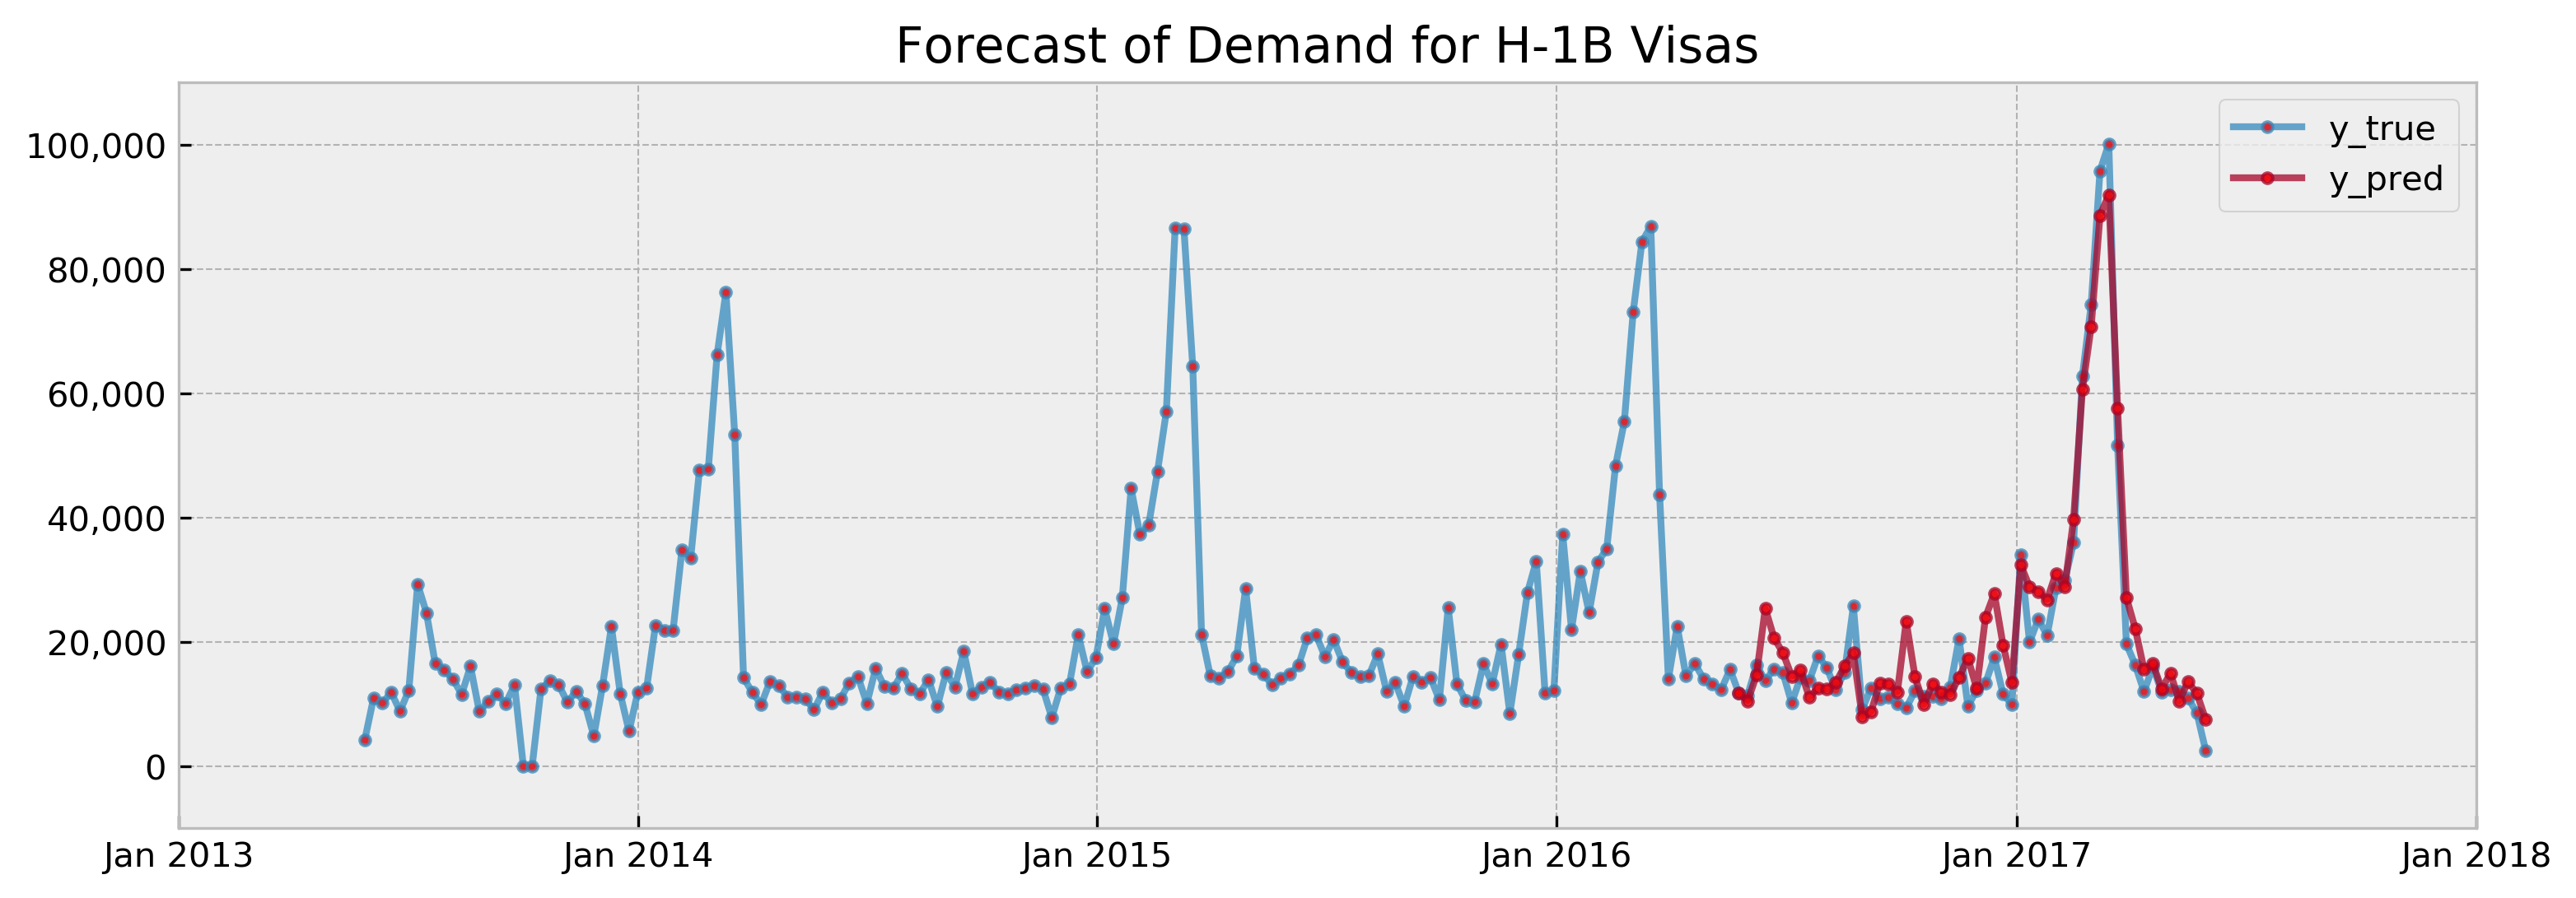

In [4]:
autoplot_test(data)